In [1]:
from iaemu_predict import Model
from model_utils import ResidualMultiTaskEncoderDecoder
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
r_bins = np.array([ 0.11441248,  0.14739182,  0.18987745,  0.24460954,  0.31511813,
           0.40595079,  0.52296592,  0.67371062,  0.8679074 ,  1.11808132,
           1.44036775,  1.85555311,  2.39041547,  3.07945165,  3.96710221,
           5.11061765,  6.58375089,  8.48151414, 10.92630678, 14.07580982]) # for plotting correlation functions

In [3]:
model = Model(ResidualMultiTaskEncoderDecoder(),
                    'iaemu.pt', # trained model file
                    'data/x_train_10x.npy', # for normalization
                    'data/y_train_10x.npy') # for normalization

/Users/snehpandya/Projects/IAEmu/src/iaemu_predict/iaemu_predict.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model_checkpoint, map_location=self.device)


In [4]:
# input has format: [ central_alignment_strength (mu_cen), satellite_alignment_strength (mu_sat), logMmin, sigma_logM, logM0, logM1, alpha ]
x = [0.36654109,  0.80600334, 11.34322895,  0.2720461,  12.05403471, 13.29433936, 1.28734969]

input = torch.tensor(x, dtype = torch.float32)
preds, aleotoric_uncertainty, epistemic_uncertainty = model.predict(x=input, predict='all', return_grad=True, num_passes=50) 
## predict='all' returns all correlation functions, return_grad disables batch norm for gradient calculation, num_passes is the number of passes for epistemic uncertainty estimation.
## if using iaemu within Hamiltonian Monte Carlo, set return_grad=True but num_passes=1.

xi, omega, eta = preds[0].detach().numpy(), preds[1].detach().numpy(), preds[2].detach().numpy()
xi_aleo, omega_aleo, eta_aleo = aleotoric_uncertainty[0].detach().numpy(), aleotoric_uncertainty[1].detach().numpy(), aleotoric_uncertainty[2].detach().numpy()
xi_epi, omega_epi, eta_epi = epistemic_uncertainty[0].detach().numpy(), epistemic_uncertainty[1].detach().numpy(), epistemic_uncertainty[2].detach().numpy()

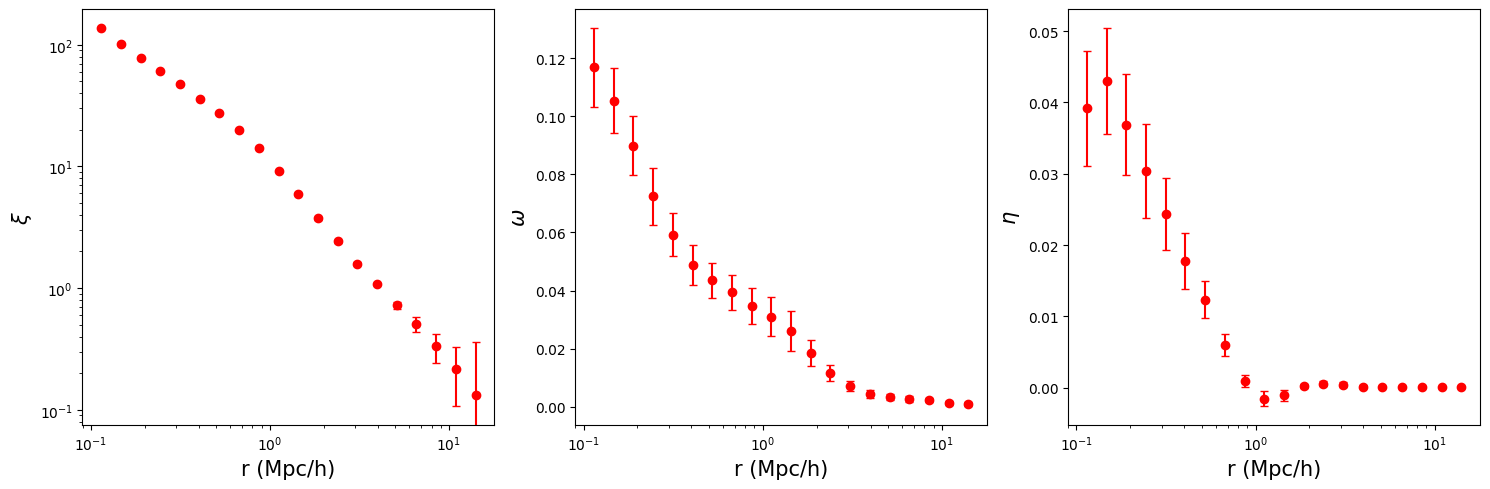

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].errorbar(r_bins, xi, yerr=xi_epi, label='xi', color  = 'red', capsize=3, fmt = 'o')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('r (Mpc/h)', fontsize=15)
axs[0].set_ylabel(r'$\xi$', fontsize=15)
# add cap size to error bars
axs[1].errorbar(r_bins, omega, yerr=omega_epi, label='omega', color = 'red', capsize=3, fmt = 'o')
axs[1].set_xscale('log')
axs[1].set_xlabel('r (Mpc/h)', fontsize=15)
axs[1].set_ylabel(r'$\omega$', fontsize=15)

axs[2].errorbar(r_bins, eta, yerr=eta_epi, label='eta', color = 'red', capsize=3, fmt = 'o')
axs[2].set_xscale('log')
axs[2].set_xlabel('r (Mpc/h)', fontsize=15)
axs[2].set_ylabel(r'$\eta$', fontsize=15)

plt.tight_layout()